In [58]:
import os
from os.path import join as pj
import pandas as pd
from tqdm import tqdm

In [59]:
%%capture
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', None)

In [60]:
dir_home      = os.path.expanduser('~')
dir_project   = '/mnt/4TB/TCGA_Lung'
path_manifest = pj(dir_project, 'scripts', '3-processing', '1-manifest.csv') 
dir_analysis  = pj(dir_project, 'scripts', '4-analysis')

In [98]:
path_matrix = '2-diffTrain_score64_combo12.pq'

In [99]:
path_matrix = pj(dir_analysis, path_matrix)

In [100]:
df = pd.read_parquet(path_matrix)

In [101]:
df.shape

(119, 49)

In [102]:
os.chdir('/mnt/4TB/AIQC')

In [103]:
pwd

'/mnt/4TB/AIQC'

In [104]:
# from aiqc import utils
# utils.config.get_config()

In [105]:
# from aiqc.orm import create_db, destroy_db

In [106]:
# destroy_db(confirm=True, rebuild=True)

## 💾 Data

In [107]:
from aiqc import orm

In [108]:
shared_dataset = orm.Dataset.Tabular.from_path(file_path=path_matrix, ingest=False)

---

## 🚰 Pipeline

Reference [High-Level API Docs](../../api_high_level.ipynb) for more information.

In [109]:
from aiqc.mlops import Pipeline, Input, Target, Stratifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [110]:
pipeline = Pipeline(
    Input(
        dataset         = shared_dataset,
        exclude_columns = ['file_id'],
        encoders        = [Input.Encoder(StandardScaler())]
    ),
        
    Target(
        dataset   = shared_dataset
        , column  = 'vital_status'
        , encoder = Target.Encoder(LabelBinarizer())
    ),

    Stratifier(
        size_test = 0.10,
        size_validation = 0.20
    )
)


└── 👟 Success - Fit StandardScaler(copy=False) on 47 columns.


└── ✅ Success - All columns now have encoders associated with them.



In [111]:
from aiqc.mlops import Experiment, Architecture, Trainer
import tensorflow as tf
from tensorflow.keras import layers as l
from aiqc.utils.tensorflow import TrainingCallback

In [112]:
def fn_build(features_shape, label_shape, **hp):
    m = tf.keras.models.Sequential()
    m.add(l.Input(shape=features_shape))

    m.add(l.Dense(hp['num_neurons'], kernel_initializer=hp['init']))
    if (hp['bn_on']==True):
        m.add(l.BatchNormalization())
    m.add(l.Activation(hp['activation']))
    m.add(l.Dropout(hp['drop_rate']))
    
    if (hp['second_layer']==True):
        m.add(l.Dense(hp['num_neurons'], kernel_initializer=hp['init']))
        if (hp['bn_on']==True):
            m.add(l.BatchNormalization())
        m.add(l.Activation(hp['activation']))
        m.add(l.Dropout(hp['drop_rate']))

    # Output layer
    m.add(l.Dense(units=label_shape[0], activation='sigmoid'))
    return m

In [113]:
def fn_train(
    model, loser, optimizer,
    train_features, train_label,
    eval_features, eval_label,
    **hp
):    
    model.compile(
        loss        = loser
        , optimizer = optimizer
        , metrics   = ['accuracy']
    )

    ## Early stopper
    metrics_cutoffs = [
        # dict(metric='accuracy', cutoff=hp['train_cutoff'], above_or_below='above'),
        dict(metric='val_accuracy', cutoff=hp['val_cutoff'], above_or_below='above'),
    ]
    cutoffs   = TrainingCallback.MetricCutoff(metrics_cutoffs)
    callbacks = [tf.keras.callbacks.History(), cutoffs]
    
    model.fit(
        train_features, train_label
        , validation_data = (eval_features, eval_label)
        , verbose = 0
        , batch_size = hp['batch_size']
        , epochs = hp['epochs']
        , callbacks = callbacks
    )
    return model

In [114]:
hyperparameters = dict(
    num_neurons     = [4]
    , second_layer  = [False]
    # , train_cutoff  = [0.91]
    , val_cutoff    = [0.955]
    , bn_on         = [False]
    , activation    = ['relu']
    , init          = ['he_uniform']
    , epochs        = [120]#90
    , batch_size    = [5]
    , drop_rate     = [0.4]
    , learning_rate = [0.0001,]#0.001
)

In [115]:
experiment = Experiment(
    Architecture(
        library           = "keras"
        , analysis_type   = "classification_binary"
        , fn_build        = fn_build
        , fn_train        = fn_train
        , hyperparameters = hyperparameters
    ),
    
    Trainer(
        pipeline        = pipeline
        , repeat_count  = 20
        , permute_count = 0
    )
)


└── 🔂 Success - created Queue consisting of 20 runs.



In [116]:
experiment.run_jobs()

└── 🔮 Queue #4:   0%|                                        | 0/20 [00:00<?, ?it/s]


└── 📈 Success - satisfied early stopping thresholds in epoch #30



└── 🔮 Queue #4:  65%|████████████████████▏          | 13/20 [01:16<00:42,  6.05s/it]


└── 📈 Success - satisfied early stopping thresholds in epoch #50



└── 🔮 Queue #4:  80%|████████████████████████▊      | 16/20 [01:31<00:21,  5.44s/it]


└── 📈 Success - satisfied early stopping thresholds in epoch #39



└── 🔮 Queue #4: 100%|███████████████████████████████| 20/20 [01:52<00:00,  5.61s/it]


In [117]:
experiment.metricsAggregate_df(
    selected_metrics = ['accuracy']
    , sort_by        = 'mean'
    , ascending      = False
).head(20)

hyperparamcombo_id  job_id  repeat_index  predictor_id    metric  maximum  \
13  4                   4       13            74            accuracy  1.000     
14  4                   4       14            75            accuracy  1.000     
7   4                   4       7             68            accuracy  1.000     
5   4                   4       5             66            accuracy  1.000     
1   4                   4       1             62            accuracy  1.000     
8   4                   4       8             69            accuracy  1.000     
12  4                   4       12            73            accuracy  1.000     
6   4                   4       6             67            accuracy  1.000     
4   4                   4       4             65            accuracy  1.000     
17  4                   4       17            78            accuracy  1.000     
2   4                   4       2             63            accuracy  0.988     
19  4                   4       19            80            accuracy  1.000     
16  4                   4       16            77            accuracy  0.958     
15  4                   4       15            76            accuracy  0.976     
10  4                   4       10            71            accuracy  1.000     
18  4                   4       18            79            accuracy  1.000     
0   4                   4       0             61            accuracy  0.958     
9   4                   4       9             70            accuracy  0.976     
11  4                   4       11            72            accuracy  1.000     
3   4                   4       3             64            accuracy  0.976     

    minimum    pstdev  median      mean  
13  0.958    0.017664  0.988   0.982000  
14  0.917    0.036627  0.988   0.968333  
7   0.917    0.036627  0.988   0.968333  
5   0.917    0.034874  0.976   0.964333  
1   0.917    0.034874  0.976   0.964333  
8   0.875    0.056311  0.988   0.954333  
12  0.875    0.056311  0.988   0.954333  
6   0.875    0.054162  0.976   0.950333  
4   0.875    0.052538  0.964   0.946333  
17  0.833    0.078725  1.000   0.944333  
2   0.917    0.033470  0.917   0.940667  
19  0.833    0.076054  0.988   0.940333  
16  0.917    0.016780  0.940   0.938333  
15  0.917    0.027813  0.917   0.936667  
10  0.833    0.073722  0.976   0.936333  
18  0.875    0.051938  0.917   0.930667  
0   0.904    0.023012  0.917   0.926333  
9   0.875    0.041427  0.917   0.922667  
11  0.792    0.085491  0.917   0.903000  
3   0.750    0.092437  0.875   0.867000

---

In [119]:
predictor = orm.Predictor.get_by_id(74)#17

In [120]:
predictor.job.queue.splitset.features[0].dataset.source_path

'/mnt/4TB/TCGA_Colorectal/scripts/4-analysis/2-diffTrain_score64_combo12.pq'

In [121]:
prediction = predictor.predictions[0]

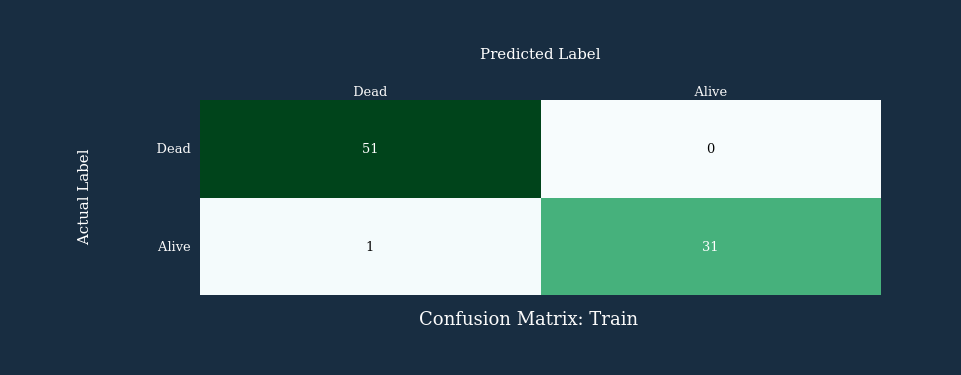

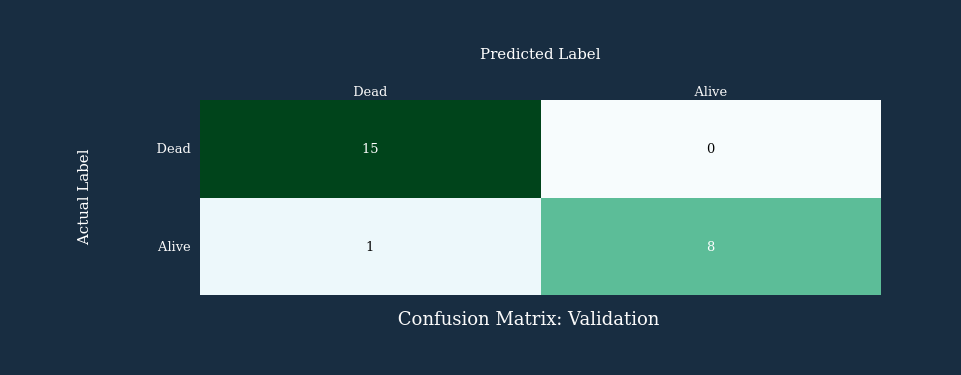

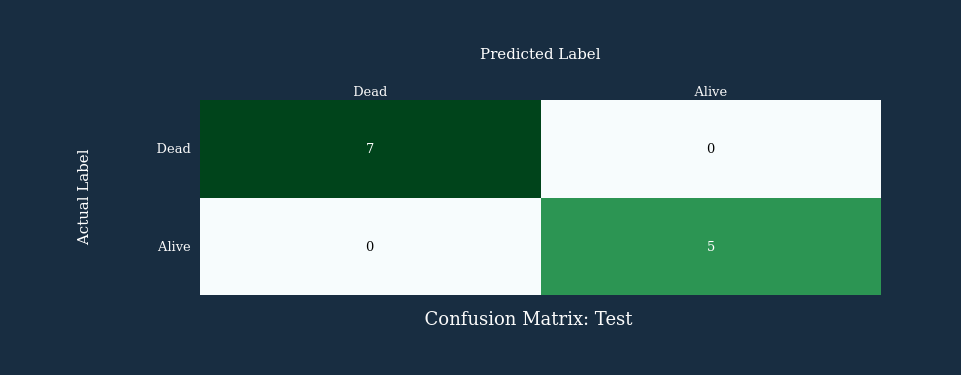

In [122]:
prediction.plot_confusion_matrix()

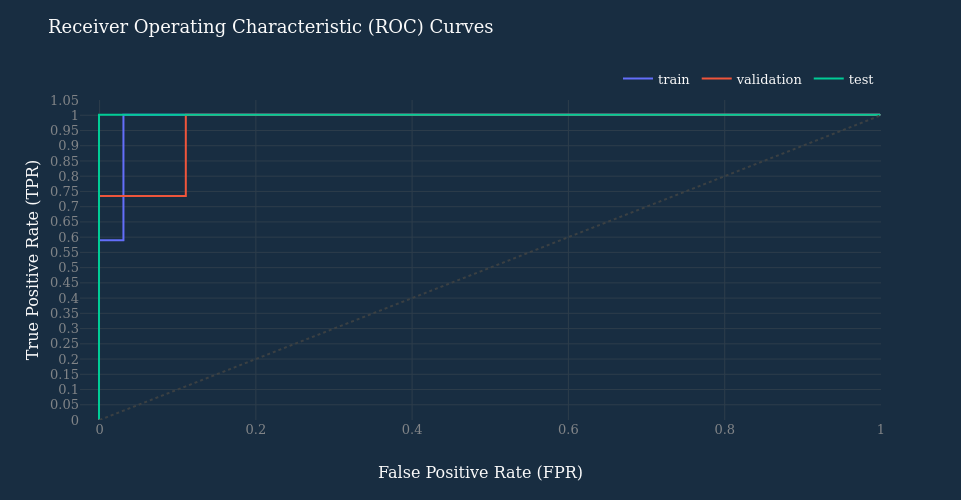

In [123]:
prediction.plot_roc_curve()

In [124]:
prediction.metrics

{'train': {'accuracy': 0.988,
  'f1': 0.99,
  'loss': 0.114,
  'precision': 0.981,
  'recall': 1.0,
  'roc_auc': 0.987},
 'validation': {'accuracy': 0.958,
  'f1': 0.968,
  'loss': 0.22,
  'precision': 0.938,
  'recall': 1.0,
  'roc_auc': 0.97},
 'test': {'accuracy': 1.0,
  'f1': 1.0,
  'loss': 0.161,
  'precision': 1.0,
  'recall': 1.0,
  'roc_auc': 1.0}}

In [125]:
prediction

<Prediction: 74>

---

In [126]:
prediction.calc_featureImportance(permute_count=99)

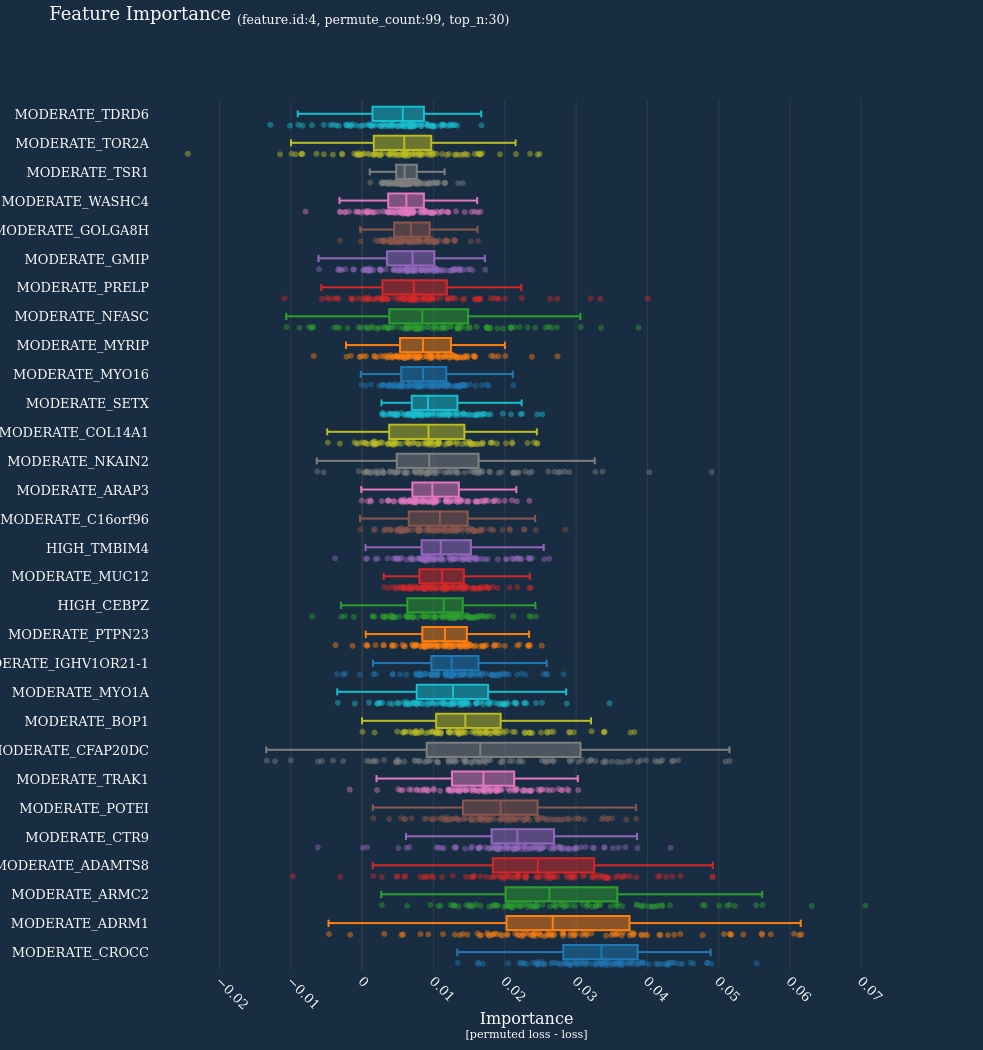

In [128]:
prediction.plot_feature_importance(top_n=30, boxpoints='all')

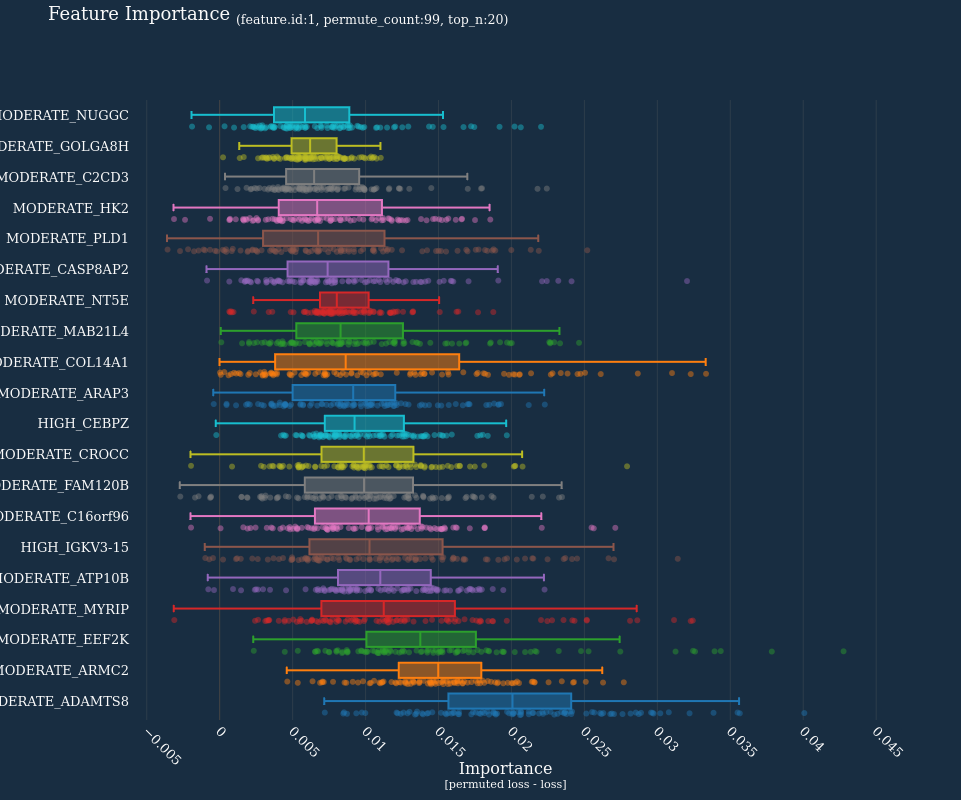

In [35]:
prediction.plot_feature_importance(top_n=20, boxpoints='all')

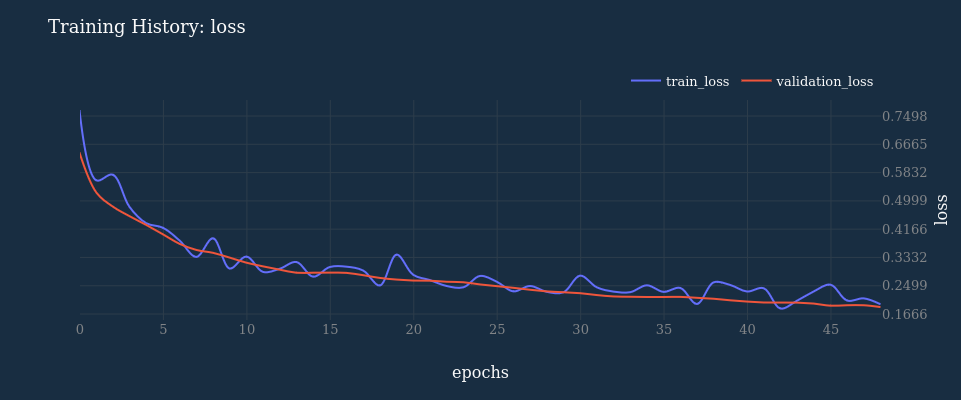

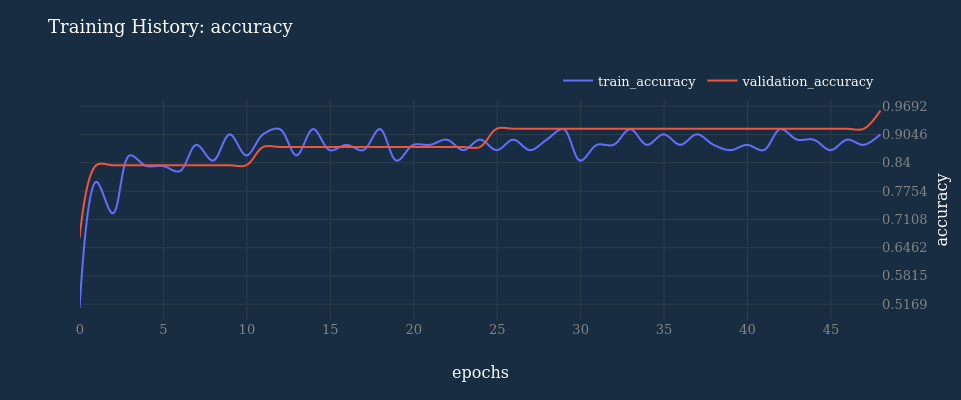

In [36]:
predictor.plot_learning_curve(skip_head=False)

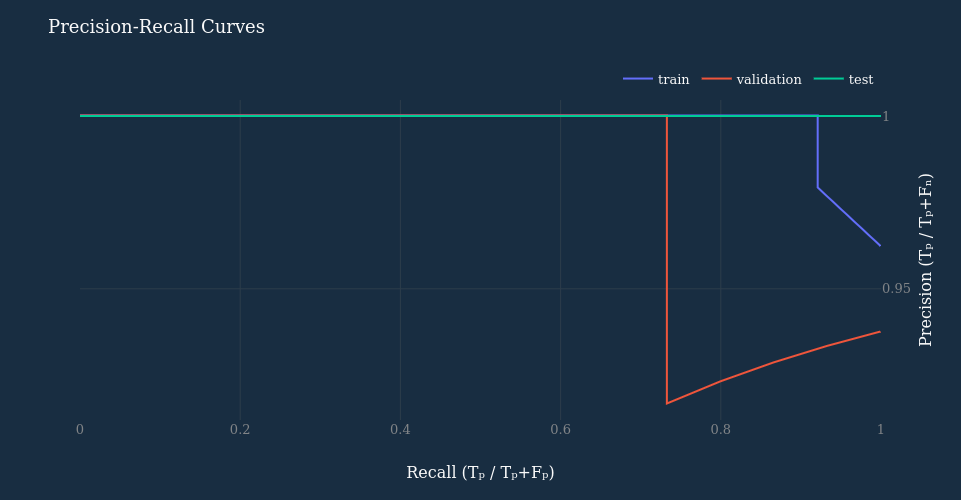

In [37]:
prediction.plot_precision_recall()